In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [2]:

def import_PV_WT_data():
    """
    Returns
    -------
    PV : dict
        Holds data regarding the PV string in SYSLAB 715
    WT : dict
        Holds data regarding the Gaia wind turbine
    """

    PV={
        "Type": "Poly-cristaline",
        "Az": 60,#deg
        "Estc": 1000, #W/m**2
        "Tstc": 25,#C
        'Pmp_stc' : [165, 125], #W
        'ganma_mp' : [-0.478/100, -0.45/100], #1/K
        'Ns':[18, 6], #int
        'Np':[2, 2], #int
        'a' : [-3.56, -3.56], #module material construction parameters a, b and D_T
        'b' : [-0.0750, -0.0750],
        'D_T' : [3, 3],# represents the difference between the module and cell temperature
                        #these three parameters correspond to glass/cell/polymer sheet with open rack
                        #they are extracted from Sandia document King, Boyson form 2004 page 20
        'eff_P' : [[0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000],
                   [0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000]],
        'eff_%' : [[0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98],
                   [0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98]],
       "index": ['A','B'], #A and B refer to each channel of the inverter, which has connected a different string.
        }

    WT={
        "Type": "Asynchronous",
        "Mode": "Passive, downwind vaning",
        "Pn": 11,#kW
        "Vn": 400,#V
        'CWs' : [3.5, 6, 8, 10, 10.5, 11, 12, 13, 13.4, 14, 16, 18, 20, 22, 24, 25,],#m/s
        'CP' : [0, 5, 8.5, 10.9, 11.2, 11.3, 11.2, 10.5, 10.5, 10, 8.8, 8.7, 8, 7.3, 6.6, 6.3,],#kW
        "Cin": 3.5,#m/s
        "Cout": 25,#m/s
        "HH": 18,#m
        "D": 13,#m
        "SA": 137.7,#m**2
        "B": 2,#int
        }

    return PV, WT


def ExpandSOLETE(data, info, Control_Var):
    """

    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    info : list
        Contains PVinfo and WTinfo which are dicts
    Control_Var : dict
        Holds information regarding what to do

    Returns
    -------
    Adds columns to data with new metrics. Some from the PV performance model [1], others from potentially useful metrics.
    """
    ncol=len(data.columns)

    print("Expanding SOLETE with King's PV Performance Model")
    data['Pac'], data['Pdc'], data['TempModule'], data['TempCell'] = PV_Performance_Model(data, info[0])
    print("Cleaning noise and curtailment from active power production")
    data['P_Solar[kW]'] =  np.where(data['Pac'] >= 1.5*data['P_Solar[kW]'],
                                    data['Pac'], data['P_Solar[kW]'])
    print("Smoothing zeros")
    data['P_Solar[kW]'] =  np.where(data['P_Solar[kW]'] <= 0.001,
                                      0, data['P_Solar[kW]'])
    data['Pac'] =  np.where(data['Pac'] <= 0.001,
                                      0, data['Pac'])

    print("\nAdding new Types with codes: " + str(Control_Var['PossibleFeatures']))


    if 'HoursOfDay' in Control_Var['PossibleFeatures']: #time of the day hours
        data['HoursOfDay'] =  data.index.hour
    if 'MeanPrevH' in Control_Var['PossibleFeatures']: #mean previous horizon
        data['MeanPrevH'] =  data[ Control_Var['IntrinsicFeature']].rolling(Control_Var['H']).mean()
    if 'StdPrevH' in Control_Var['PossibleFeatures']: #std previous horizon
        data['StdPrevH'] =  data[Control_Var['IntrinsicFeature']].rolling(Control_Var['H']).std()
    if 'MeanWindSpeedPrevH' in Control_Var['PossibleFeatures']: #wind speed mean of the previous horizon
        data['MeanWindSpeedPrevH'] =  data['WIND_SPEED[m1s]'].rolling(Control_Var['H']).mean()
    if 'StdWindSpeedPrevH' in Control_Var['PossibleFeatures']: #wind speed std of the previous horizon
        data['StdWindSpeedPrevH'] =  data['WIND_SPEED[m1s]'].rolling(Control_Var['H']).std()


    print("\nSOLETE has been successfully expanded from:", ncol, "to:", len(data.columns), "features.\n\n")


    pass


def PV_Performance_Model(data, PVinfo, colirra='POA Irr[kW1m2]'):
    """
    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    PVinfo : dict
        A bunch of parameters extracted from the datasheet and other supporting documents
        Check function: import_PV_WT_data for further details
    colirra : string
        holds Epoa, that is the irradiance in the plane of the array.
        If you reuse this code, make sure you are feeding Epoa and not GHI
        The default is 'POA Irr[kW1m2]'.
    Returns
    -------
    DataFrames
        Pac, Pdc, Tm, and Tc. [1]
    """


    # Obtains the expected solar production based on irradiance, temperature, pv parameters, etc
    DATA_PV = pd.DataFrame({'Pmp_stc' : PVinfo["Pmp_stc"],
                            'ganma_mp' : PVinfo['ganma_mp'],
                            'Ns': PVinfo['Ns'],
                            'Np': PVinfo['Np'],
                            'a' : PVinfo['a'],
                            'b' : PVinfo['b'],
                            'D_T' : PVinfo['D_T'],
                            'eff_P' : PVinfo['eff_P'],
                            'eff_%' : PVinfo['eff_%'],
                            },
                           index = PVinfo["index"])

    DATA_PV['eff_max_%'] = [max(DATA_PV['eff_%'].loc['A']), max(DATA_PV['eff_%'].loc['B'])] #maximum inverter efficiency in %
    DATA_PV['eff_max_P'] = [max(DATA_PV['eff_P'].loc['A']), max(DATA_PV['eff_P'].loc['B'])] #W maximum power output of the inverter

    Results = pd.DataFrame(index = data.index)

    for pv in DATA_PV.index:
        #Temperature Module
        Results['Tm_' + pv] = data['TEMPERATURE[degC]'] + data[colirra]*1000 *np.exp(DATA_PV.loc[pv,'a']+DATA_PV.loc[pv,'b']*data['WIND_SPEED[m1s]'])
        #Temperature Cell
        Results['Tc_' + pv] = Results['Tm_' + pv] + data[colirra]*1000/PVinfo["Estc"] * DATA_PV.loc[pv,'D_T']
        #power produced in one single pannel
        Results['Pmp_panel_' + pv] = data[colirra]*1000/PVinfo["Estc"] * DATA_PV.loc[pv, 'Pmp_stc'] * (1+DATA_PV.loc[pv, 'ganma_mp'] * (Results['Tc_' + pv] - PVinfo["Tstc"]) )
        #power produced by all the panels in the array
        Results['Pmp_array_' + pv] = DATA_PV.loc[pv, 'Ns'] * DATA_PV.loc[pv, 'Np'] * Results['Pmp_panel_' + pv]
        #efficiency of the inverter corresponding to the instantaneous power output
        Results['eff_inv_' + pv] =  np.interp(Results['Pmp_array_' + pv], DATA_PV.loc[pv, 'eff_P'], DATA_PV.loc[pv, 'eff_%'], left=0)/100


        Results['Pac_' + pv] =  DATA_PV.loc[pv, 'eff_max_%']/100 * Results['Pmp_array_' + pv]
        Results[Results['Pac_' + pv]>DATA_PV.loc[pv, 'eff_max_P']]=DATA_PV.loc[pv, 'eff_max_P'] #If any of the Pac is > than the maximum capacity of the inverter
        # then use the max capacity of the inverter
        Results[Results['Pac_' + pv]<0]=0

    return Results[['Pac_A', 'Pac_B']].sum(axis=1)/1000, Results[['Pmp_array_A', 'Pmp_array_B']].sum(axis=1)/1000, Results[['Tm_A', 'Tm_B']].mean(axis=1), Results[['Tc_A', 'Tc_B']].mean(axis=1)

def TimePeriods(data, control):
    """
    A function that will split the time series to input and output for training
    of the forecast problem with supervised learning
    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    control : dict
        Control_Var.
    Returns
    -------
    dik : dict of DataFrames
        cotains the train and testing sets for RF and SVM
        or the train, validation and testing for ANN

    Arguments
    ---------
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        base: Is the basic variable that will be shifted back and forward in time, e.g. Pestimated
        additions: are the other variables that will tag along base to complete the dataset
        train_val_test = division of timestamps in the three blocks
    """
    n_in=control["PRE"]
    n_out=control["H"]
    base=control["IntrinsicFeature"]
    additions= control["PossibleFeatures"].copy()
    #additions.remove(control["IntrinsicFeature"])
    train_val_test = control['Train_Val_Test']

    if control['MLtype'] in ['RF', 'SVM']:
        data.fillna(0, inplace=True)

        BASE = series_to_supervised(data[base], n_in, n_out, dropnan=False)

        col_loc_base = []
        for addition in additions:
            BASE[addition] = data[addition]
            col_loc_base.append(BASE.columns.get_loc(addition))


        BASE.dropna(inplace=True)


        X_COLS = [*range(0,n_in+1)]+col_loc_base  #because they are the PRE+t0 current sample
        Y_COLS = [*range(n_in+1,n_in+n_out+1)]

        X=BASE.iloc[:, X_COLS]
        Y=BASE.iloc[:, Y_COLS]
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=train_val_test[-1]/100, shuffle=False, random_state=None)

        Scaler = {
                  'X_data' : 1,
                  'Y_data' : 1,
                  }


        ML_DATA = {
            "X_TRAIN": X_TRAIN.sort_index(),
            "X_TEST": X_TEST.sort_index(),
            "Y_TRAIN": Y_TRAIN.sort_index(),
            "Y_TEST": Y_TEST.sort_index(),
            "Y_TEST_abs": Y_TEST.sort_index(),
            }


    elif control['MLtype'] in ['LSTM', 'CNN', 'CNN_LSTM']:
        Xscaler = MinMaxScaler(feature_range=(0, 1)) #initialise the scaler
        Yscaler = MinMaxScaler(feature_range=(0, 1)) #initialise the scaler

        X = data[additions]
        Y = data[base]

        X = series_to_forecast(X, n_in, 0, dropnan=False)#.drop(X.index[-(n_out):])
        Y = series_to_forecast(Y, 0, n_out, dropnan=False).drop(base+'_(t)', axis=1)#.drop(Y.index[:(n_in)])

        X_TRAIN, X_VAL_TEST, Y_TRAIN, Y_VAL_TEST = train_test_split(X, Y, train_size=train_val_test[0]/100, shuffle=False, random_state=None)

        del X, Y

        X_VAL, X_TEST, Y_VAL, Y_TEST = train_test_split(X_VAL_TEST, Y_VAL_TEST, train_size=train_val_test[1]/(100-train_val_test[0]), shuffle=False, random_state=None)

        del X_VAL_TEST, Y_VAL_TEST

        #apply scaler to keep all values between 0 and 1
        X_TRAIN = pd.DataFrame(Xscaler.fit_transform(X_TRAIN), index=X_TRAIN.index, columns = X_TRAIN.columns)
        X_VAL = pd.DataFrame(Xscaler.transform(X_VAL), index=X_VAL.index, columns = X_VAL.columns)
        X_TEST = pd.DataFrame(Xscaler.transform(X_TEST), index=X_TEST.index, columns = X_TEST.columns)

        Y_TRAIN = pd.DataFrame(Yscaler.fit_transform(Y_TRAIN), index=Y_TRAIN.index, columns = Y_TRAIN.columns)
        Y_VAL = pd.DataFrame(Yscaler.transform(Y_VAL), index=Y_VAL.index, columns = Y_VAL.columns)
        Y_TEST_abs = pd.DataFrame(Y_TEST, index=Y_TEST.index, columns = Y_TEST.columns)
        Y_TEST = pd.DataFrame(Yscaler.transform(Y_TEST), index=Y_TEST.index, columns = Y_TEST.columns)


        # apply masking as to substitute a complete row by 999 if any of its values is NAN (aka missing value)
        X_TRAIN.mask(X_TRAIN.isna().any(axis=1), other=999, inplace=True)
        X_VAL.mask(X_VAL.isna().any(axis=1), other=999, inplace=True)
        X_TEST.mask(X_TEST.isna().any(axis=1), other=999, inplace=True)

        Y_TRAIN.mask(Y_TRAIN.isna().any(axis=1), other=999, inplace=True)
        Y_VAL.mask(Y_VAL.isna().any(axis=1), other=999, inplace=True)
        Y_TEST.mask(Y_TEST.isna().any(axis=1), other=999, inplace=True)
        Y_TEST_abs.mask(Y_TEST_abs.isna().any(axis=1), other=999, inplace=True)


        Scaler = {
                  'X_data' : Xscaler,
                  'Y_data' : Yscaler,
                  }

        ML_DATA = {
            "X_TRAIN": X_TRAIN.sort_index(),
            "X_VAL": X_VAL.sort_index(),
            "X_TEST": X_TEST.sort_index().drop(X_TEST.tail(n_out).index, axis=0),
            "Y_TRAIN": Y_TRAIN.sort_index(),
            "Y_VAL": Y_VAL.sort_index(),
            "Y_TEST": Y_TEST.sort_index().drop(Y_TEST.tail(n_out).index, axis=0),
            "Y_TEST_abs": Y_TEST_abs.sort_index().drop(Y_TEST.tail(n_out).index, axis=0),
            }

    else:
        print("\n\n\n WARNING: Your ML method is not supported by the 'TimePeriods' function.\n\n")

    return ML_DATA, Scaler


def series_to_forecast(data, n_in, n_out, dropnan=True):
    """
    A function that will split the time series to input and output for training
    of the forecast problem with supervised learning
    Arguments:
        data: Sequence of observations as a list, NumPy array or pandas series
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """

    # n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    COLUMNS = df.columns
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(col_name + '_(t-%d)' % (i)) for col_name in COLUMNS]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out+1):
        cols.append(df.shift(-i))

        if i == 0:
            names += [(col_name + '_(t)') for col_name in COLUMNS]
        else:
            names += [(col_name + '_(t+%d)' % (i)) for col_name in COLUMNS]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
"""
Created on Wed Nov 17 14:35:08 2021
@author: Daniel Vázquez Pombo
email: dvapo@elektro.dtu.dk
LinkedIn: https://www.linkedin.com/in/dvp/
ResearchGate: https://www.researchgate.net/profile/Daniel-Vazquez-Pombo
The purpose of this script is to give you a running example of the methodology presented in:
    [1] D.V. Pombo, H.W. Bindner, S.V. Spataru, P. Sørensen, P. Bacher,
    Increasing the Accuracy of Hourly Multi-Output Solar Power Forecast with
    Physics-Informed Machine Learning, Solar Energy. In Press.

It should run without errors simply by placing all the files in the same location.
We have checked the hdf5 file (the actual dataset) compatibility with both Python and R.
The lincensing of this work is pretty chill, just give credit: https://creativecommons.org/licenses/by/4.0/
How to use the first time:
    1- Put all the files in the same folder and click run. If you get the message "Done!" in the console that is it.
    2- If it didn't work:
        a) Check the dependencies:
            Python 3.8.10
            Pandas 1.2.4
            Numpy 1.19.5
            Matplotlib 3.4.2
            Scikit-Learn 0.24.2
            Keras 2.5.0
            TensorFlow 2.5.0
        b) If that didn't solve it... You have a problem my friend ¯\_(ツ)_/¯

How to use the second and subsequent times:
    1- Go to section: "Control the Script"
        In the dictionary called Control_Var you can modify different values, like the horizon to forecast,
        the division between training, validation and testing, what is the metric to be predicted, which
        should be used as extrinsic features, etc.
    2- Go to section: Define Machine Learning Configuration and Hyperparameters
        You can use those dictionaries to define different topologies for the 5 ML methods covered in [1]
        However, be careful with ANN, they have a particular shape, you cant control each layer's position
        from there. But you can edit that yourself.
    3- After setting those parameters just run it. Take into account the size of the data, it might take a while.
    4- If you found this useful, and want to send some kudos, do so.
DISCLAIMERS:
1- I was using a regular PC only for coding, models were run in an HPC.
2- There are better ways to configure the ML-models, have fun playing with it.
3- SVM will take for ever if run in this way for the whole set. An alternative formulation is -> https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python
4- I put together the dataset and this scripts in one day, so do not expect them to be pretty or 100% error free.
"""

import pandas as pd
#from Functions import import_PV_WT_data, ExpandSOLETE, TimePeriods, PrepareMLmodel, TestMLmodel, get_results, post_process



#%% Control The Script:

Control_Var = {
    '_description_' : 'Holds all the variables that define the behaviour of the algoritm',
    'trainVSimport' : True, #True - trains the ML model, False - imports the model
    'saveMLmodel' : True, #saves the trained model if True, but also trainVSimport must be True, otherwise does nothing.
    'Train_Val_Test' : [70, 20, 10], #train validation test division of the available DATA
    'IntrinsicFeature' : 'P_Solar[kW]', #feature to be predicted
    'PossibleFeatures': ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]',
                        'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'Pressure[mbar]',
                        'Pac', 'Pdc','TempModule', 'TempCell', 'HoursOfDay', 'MeanPrevH',
                        'StdPrevH', 'MeanWindSpeedPrevH', 'StdWindSpeedPrevH',
                        ],
    #'IntrinsicFeature' : 'Power',
    #'PossibleFeatures': ['Time','WindSpeed','Power'
                        #],
    'MLtype' : 'CNN_LSTM', #RF SVM LSTM CNN CNN_LSTM
    'H' : 24, #horizon length in number of samples
    # 'Features_IDs' : pd.DataFrame(Control_Var['PossibleFeatures'], columns = ['Features']),
    'PRE' : 30, #previous samples to be used in the predictor
    }

#%% Define Machine Learning Configuration and Hyperparameters
# edit this dictionaries to tailor-made the ML model that you want

RF = {'_description_' : 'Holds the values related to Random Forest',
        'n_trees' : 1, #number of trees
        'random_state' : 32, #initialization number, can be removed for random seed generation
        }

SVM = {'_description_' : 'Holds the values related to Support Vector Machine',
       'kernel' : 'rbf', #‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ <--> default=’rbf’
        'degree' : 3, # Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
        'gamma' : 'scale', # ‘scale’, ‘auto’ -> if you don't know what you are doing leave it as scale
        'coef0' : 0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
        'C' : 3, # Regularization parameter. The strength of the regularization is inversely proportional to C.
                # Must be strictly positive. The penalty is a squared l2 penalty.
        'epsilon' : 0.1, # Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty
                        # is associated in the training loss function with points predicted within a distance epsilon from the actual value.
        }

LSTM = {'_description_' : 'Holds the values related to LSTM ANN design',
        'n_batch' : 16, #int <-> # number of samples fed together - helps with paralelization  (smaller takes longer, improves performance carefull with overfitting)
        'epo_num' : 1000, # 5 - epoc number of iterations of each batch - same reasoning as for the batches'
        'Neurons' : [15,15,15], #number of neurons per layer <-> you can feed up to three layers using list e.g. [15, 10] makes two layers of 15 and 10 neurons, respectively.
        'Dense'  : [0, 0], #number of dense layers and neurons in them. If left as 0 they are not created.
        'ActFun' : 'tanh', #sigmoid, tanh, elu, relu - activation function as a str
        'LossFun' : 'mean_absolute_error', #mean_absolute_error or mean_squared_error
        'Optimizer' : 'adam' # adam RMSProp - optimization method adam is the default of the guild
        }

CNN = {'_description_' : 'Holds the values related to LSTM NN design',
        'n_batch' : 16, #see note in LSTM
        'epo_num' : 3, #see note in LSTM
        'filters' : 32, #number of nodes per layer, usually top layers have higher values
        'kernel_size' : 2, #size of the filter used to extract features
        'pool_size' : 3, #down sampling feature maps in order to gain robustness to changes
        'Dense'  : [10, 10],#see note in LSTM
        'ActFun' : 'tanh', #see note in LSTM
        'LossFun' : 'mean_absolute_error', #see note in LSTM
        'Optimizer' : 'adam' #see note in LSTM
        }

CNN_LSTM = {'_description_' : 'Holds the values related to LSTM NN design',
        'n_batch' : 32, #see note in LSTM
        'epo_num' : 35, #see note in LSTM
        'filters' : 96, #see note in CNN
        'kernel_size' : 2, #see note in CNN
        'pool_size' : 2, #see note in CNN
        'Dense'  : [0,0], #see note in LSTM
        'CNNActFun' : 'sigmoid', #see note in CNN

        'Neurons' : [32,32], #see note in LSTM
        'LSTMActFun' : 'sigmoid', #see note in LSTM

        'LossFun' : 'mse', #see note in LSTM
        'Optimizer' : 'adam' #see note in LSTM
        }

Control_Var['RF'] = RF
Control_Var['SVM'] = SVM
Control_Var['LSTM'] = LSTM
Control_Var['CNN'] = CNN
Control_Var['CNN_LSTM'] = CNN_LSTM
del RF, SVM, LSTM, CNN, CNN_LSTM

In [ ]:
DATA=pd.read_hdf('/content/SOLETE_Pombo_60min.h5')
# DATA=pd.read_csv('/content/Wind Time Series Dataset(10min).csv')
PVinfo, WTinfo = import_PV_WT_data()

#%% Expand Dataset
ExpandSOLETE(DATA, [PVinfo, WTinfo], Control_Var)

Expanding SOLETE with King's PV Performance Model
Cleaning noise and curtailment from active power production
Smoothing zeros

Adding new Types with codes: ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]', 'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'Pressure[mbar]', 'Pac', 'Pdc', 'TempModule', 'TempCell', 'HoursOfDay', 'MeanPrevH', 'StdPrevH', 'MeanWindSpeedPrevH', 'StdWindSpeedPrevH']

SOLETE has been successfully expanded from: 9 to: 18 features.




In [ ]:
DATA.shape

(10969, 18)

In [ ]:
DATA

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],Pac,Pdc,TempModule,TempCell,HoursOfDay,MeanPrevH,StdPrevH,MeanWindSpeedPrevH,StdWindSpeedPrevH
2018-06-01 00:00:00,14.165157,0.700000,1.306307,109.657127,0.000000,0.000000,0.037694,0.000000,1017.473418,0.000000,0.000000,14.165157,14.165157,0,NaN,NaN,NaN,NaN
2018-06-01 01:00:00,13.392278,0.700000,1.018417,117.161389,0.000000,0.000000,0.009697,0.000000,1017.223940,0.000000,0.000000,13.392278,13.392278,1,NaN,NaN,NaN,NaN
2018-06-01 02:00:00,13.047472,0.701278,1.094333,102.706111,0.002930,0.003503,0.000000,0.026999,1017.017803,0.026999,0.027522,13.139245,13.149754,2,NaN,NaN,NaN,NaN
2018-06-01 03:00:00,13.105583,0.731361,0.750222,68.054722,0.035402,0.021412,0.000000,0.164586,1016.676217,0.164586,0.167774,13.681197,13.745433,3,NaN,NaN,NaN,NaN
2018-06-01 04:00:00,14.680333,0.700000,1.069194,79.820556,0.117444,0.050737,0.000392,0.276209,1016.733249,0.385764,0.393235,16.012037,16.164247,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 20:00:00,21.335389,0.889889,3.722111,130.650278,0.000000,0.000000,2.152143,0.000000,1008.972336,0.000000,0.000000,21.335389,21.335389,20,1.504072,1.881161,2.669076,0.981934
2019-08-31 21:00:00,21.059806,0.799056,4.059889,146.730278,0.000000,0.000000,3.336433,0.000000,1008.197503,0.000000,0.000000,21.059806,21.059806,21,1.504072,1.881161,2.763019,1.003317
2019-08-31 22:00:00,21.504611,0.793528,3.859694,134.532222,0.000000,0.000000,2.231966,0.000000,1007.203666,0.000000,0.000000,21.504611,21.504611,22,1.504072,1.881161,2.854065,0.999390
2019-08-31 23:00:00,20.802500,0.799444,1.578861,144.713333,0.000000,0.000000,0.350245,0.000000,1006.005138,0.000000,0.000000,20.802500,20.802500,23,1.504072,1.881161,2.850750,1.003651


#trial of wavelets

In [ ]:
import pywt

In [ ]:
# Function to apply wavelet transform to a column
def column_wavelet_transform(column, wavelet='db4', level=4):
    coefficients = pywt.wavedec(column, wavelet, level=level)
    return np.concatenate(coefficients)

# Apply wavelet transform to WIND_SPEED and WIND_DIR columns
for column in ['WIND_SPEED[m1s]', 'WIND_DIR[deg]']:
    transformed_column = column_wavelet_transform(DATA[column])
    original_length = len(DATA[column])
    transformed_length = len(transformed_column)
    if transformed_length > original_length:
        transformed_column = transformed_column[:original_length]
    else:
        transformed_column = np.pad(transformed_column, (0, original_length - transformed_length), 'constant')
    DATA[f'{column}_transformed'] = transformed_column

# Create DataFrame with only transformed WIND_SPEED and WIND_DIR columns
df_transformed = DATA[['WIND_SPEED[m1s]_transformed', 'WIND_DIR[deg]_transformed']]

# Display the transformed DataFrame
print("Transformed DataFrame:")
print(df_transformed.head())



Transformed DataFrame:
                     WIND_SPEED[m1s]_transformed  WIND_DIR[deg]_transformed
2018-06-01 00:00:00                     4.387360                 383.104700
2018-06-01 01:00:00                     4.297754                 379.642433
2018-06-01 02:00:00                     4.400272                 394.926514
2018-06-01 03:00:00                     4.459104                 390.799545
2018-06-01 04:00:00                     3.726001                 333.411612


In [ ]:
DATA = pd.concat([df_transformed, DATA[['P_Solar[kW]']]], axis=1)
# Reset index to ensure 'Time' is not duplicated
DATA.reset_index(inplace=True)
# Display the concatenated DataFrame
print(DATA.head())

                index  WIND_SPEED[m1s]_transformed  WIND_DIR[deg]_transformed  \
0 2018-06-01 00:00:00                     4.387360                 383.104700   
1 2018-06-01 01:00:00                     4.297754                 379.642433   
2 2018-06-01 02:00:00                     4.400272                 394.926514   
3 2018-06-01 03:00:00                     4.459104                 390.799545   
4 2018-06-01 04:00:00                     3.726001                 333.411612   

   P_Solar[kW]  
0     0.000000  
1     0.000000  
2     0.026999  
3     0.164586  
4     0.276209  


In [ ]:
DATA

,index,WIND_SPEED[m1s]_transformed,WIND_DIR[deg]_transformed,P_Solar[kW]
0,2018-06-01 00:00:00,4.387360,383.104700,0.000000
1,2018-06-01 01:00:00,4.297754,379.642433,0.000000
2,2018-06-01 02:00:00,4.400272,394.926514,0.026999
3,2018-06-01 03:00:00,4.459104,390.799545,0.164586
4,2018-06-01 04:00:00,3.726001,333.411612,0.276209
...,...,...,...,...
10964,2019-08-31 20:00:00,-0.156809,16.527114,0.000000
10965,2019-08-31 21:00:00,0.618650,14.474489,0.000000
10966,2019-08-31 22:00:00,0.019686,-7.529003,0.000000
10967,2019-08-31 23:00:00,-0.233524,-3.372840,0.000000


In [ ]:
DATA['index'] = pd.to_datetime(DATA['index'])
DATA.set_index('index', inplace=True)

In [ ]:
DATA

,WIND_SPEED[m1s]_transformed,WIND_DIR[deg]_transformed,P_Solar[kW]
index,,,
2018-06-01 00:00:00,4.387360,383.104700,0.000000
2018-06-01 01:00:00,4.297754,379.642433,0.000000
2018-06-01 02:00:00,4.400272,394.926514,0.026999
2018-06-01 03:00:00,4.459104,390.799545,0.164586
2018-06-01 04:00:00,3.726001,333.411612,0.276209
...,...,...,...
2019-08-31 20:00:00,-0.156809,16.527114,0.000000
2019-08-31 21:00:00,0.618650,14.474489,0.000000
2019-08-31 22:00:00,0.019686,-7.529003,0.000000


In [ ]:
# target_sensor = " "

target_sensor = "P_Solar[kW]"
# features = list(DATA.columns.difference([target_sensor]))
features = DATA.columns[:2]


forecast_lead = 24
target = f"{target_sensor}_lead{forecast_lead}"

DATA[target] = DATA[target_sensor].shift(-forecast_lead)
df = DATA.iloc[:-forecast_lead]

In [ ]:
features

Index(['WIND_SPEED[m1s]_transformed', 'WIND_DIR[deg]_transformed'], dtype='object')

In [ ]:
df.shape

(10945, 4)

In [ ]:
df.head()

,WIND_SPEED[m1s]_transformed,WIND_DIR[deg]_transformed,P_Solar[kW],P_Solar[kW]_lead24
index,,,,
2018-06-01 00:00:00,4.387360,383.104700,0.000000,0.000000
2018-06-01 01:00:00,4.297754,379.642433,0.000000,0.000000
2018-06-01 02:00:00,4.400272,394.926514,0.026999,0.031438
2018-06-01 03:00:00,4.459104,390.799545,0.164586,0.172654
2018-06-01 04:00:00,3.726001,333.411612,0.276209,0.233629


In [ ]:
df=df.dropna()
df.shape

(10945, 4)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train,df_test = train_test_split(df,test_size=0.3, shuffle=False, random_state=42)

In [ ]:
test_start = "2019-04-30"

df_train_org = df.loc[:test_start].copy()
df_test_org = df.loc[test_start:].copy()
df_train = df_train_org
df_test = df_test_org
print("Test set fraction:", len(df_test_org) / len(df))

Test set fraction: 0.26980356327089994


In [ ]:
df_train.shape
df_train

,WIND_SPEED[m1s]_transformed,WIND_DIR[deg]_transformed,P_Solar[kW],P_Solar[kW]_lead24
index,,,,
2018-06-01 00:00:00,4.387360,383.104700,0.000000,0.000000
2018-06-01 01:00:00,4.297754,379.642433,0.000000,0.000000
2018-06-01 02:00:00,4.400272,394.926514,0.026999,0.031438
2018-06-01 03:00:00,4.459104,390.799545,0.164586,0.172654
2018-06-01 04:00:00,3.726001,333.411612,0.276209,0.233629
...,...,...,...,...
2019-04-30 19:00:00,-0.300082,-4.791265,0.000000,0.000000
2019-04-30 20:00:00,-0.493678,4.157186,0.000000,0.000000
2019-04-30 21:00:00,-0.602469,-0.096955,0.000000,0.000000


In [ ]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev


In [ ]:
df_train.head()

,WIND_SPEED[m1s]_transformed,WIND_DIR[deg]_transformed,P_Solar[kW],P_Solar[kW]_lead24
index,,,,
2018-06-01 00:00:00,0.654376,1.221196,-0.562651,-0.561902
2018-06-01 01:00:00,0.635531,1.207446,-0.562651,-0.561902
2018-06-01 02:00:00,0.657092,1.268144,-0.545919,-0.542373
2018-06-01 03:00:00,0.669465,1.251755,-0.460651,-0.454652
2018-06-01 04:00:00,0.515286,1.023845,-0.391473,-0.416775


In [ ]:
target

'P_Solar[kW]_lead24'

In [ ]:
features

Index(['WIND_SPEED[m1s]_transformed', 'WIND_DIR[deg]_transformed'], dtype='object')

In [ ]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=128):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(101)

batch_size = 32
sequence_length = 24


train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


X, y = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 24, 2])
Target shape: torch.Size([32])


### LSTM

#here input size is changed from 1 to 4

In [ ]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        self.c1 = nn.Conv1d(in_channels=24, out_channels=96, kernel_size = 1, stride = 1)
        self.lstm = nn.LSTM(
            input_size=2,
            hidden_size=150,
            batch_first=True,
            num_layers=self.num_layers
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.c1(x)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [ ]:
learning_rate = 5e-5
num_hidden_units = 150

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Add these lists to store the training and validation losses
train_losses = []
test_losses = []



In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)  # Append the train loss
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    test_losses.append(avg_loss)  # Append the test loss
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(7):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 1.0006220351944688

Epoch 0
---------
Train loss: 0.9995715658503225
Test loss: 0.9891934180131523

Epoch 1
---------
Train loss: 0.9947663407283001
Test loss: 0.9884413173121791

Epoch 2
---------
Train loss: 0.9892233658834283
Test loss: 1.0011036184526259

Epoch 3
---------
Train loss: 0.9883899585421817
Test loss: 0.9993047191891619

Epoch 4
---------
Train loss: 0.9878322675052392
Test loss: 0.9983206317629866

Epoch 5
---------
Train loss: 0.9892163598442457
Test loss: 0.9967994459213749

Epoch 6
---------
Train loss: 0.9874944582403419
Test loss: 0.9988782950626907



In [ ]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
df_test_pred = df_test[[target, ystar_col]]
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean
for c in df_test.columns:
    df_test[c] = df_test[c] * target_stdev + target_mean

print(df_test_pred)

                     P_Solar[kW]_lead24  Model forecast
index                                                  
2019-04-30 00:00:00           -0.561902        0.039469
2019-04-30 01:00:00           -0.561902        0.027542
2019-04-30 02:00:00           -0.561902        0.017558
2019-04-30 03:00:00           -0.548769        0.007725
2019-04-30 04:00:00           -0.507663        0.010966
...                                 ...             ...
2019-08-30 20:00:00           -0.561902       -0.030939
2019-08-30 21:00:00           -0.561902       -0.034929
2019-08-30 22:00:00           -0.561902       -0.028493
2019-08-30 23:00:00           -0.561902       -0.032117
2019-08-31 00:00:00           -0.561902       -0.031097

[2953 rows x 2 columns]


In [ ]:
df_test_pred

,P_Solar[kW]_lead24,Model forecast
index,,
2019-04-30 00:00:00,-0.561902,0.039469
2019-04-30 01:00:00,-0.561902,0.027542
2019-04-30 02:00:00,-0.561902,0.017558
2019-04-30 03:00:00,-0.548769,0.007725
2019-04-30 04:00:00,-0.507663,0.010966
...,...,...
2019-08-30 20:00:00,-0.561902,-0.030939
2019-08-30 21:00:00,-0.561902,-0.034929
2019-08-30 22:00:00,-0.561902,-0.028493


In [ ]:
df_out['Model forecast']

index
2018-06-01 00:00:00    1.103022
2018-06-01 01:00:00    1.102518
2018-06-01 02:00:00    1.103460
2018-06-01 03:00:00    1.104096
2018-06-01 04:00:00    1.099174
                         ...   
2019-08-30 20:00:00    0.854753
2019-08-30 21:00:00    0.848329
2019-08-30 22:00:00    0.858690
2019-08-30 23:00:00    0.852856
2019-08-31 00:00:00    0.854499
Name: Model forecast, Length: 10969, dtype: float32

In [ ]:
df_test

,WIND_SPEED[m1s]_transformed,WIND_DIR[deg]_transformed,P_Solar[kW],P_Solar[kW]_lead24,Model forecast
index,,,,,
2019-04-30 00:00:00,1.168219,1.671960,-0.001205,1.110223e-16,0.968097
2019-04-30 01:00:00,0.405794,0.354633,-0.001205,1.110223e-16,0.948897
2019-04-30 02:00:00,0.350726,0.454226,-0.001205,1.110223e-16,0.932824
2019-04-30 03:00:00,0.430486,0.422877,0.031659,2.114298e-02,0.916996
2019-04-30 04:00:00,0.099934,0.401054,0.222945,8.731614e-02,0.922212
...,...,...,...,...,...
2019-08-30 20:00:00,0.688652,0.442143,-0.001205,1.110223e-16,0.854753
2019-08-30 21:00:00,0.354816,0.325450,-0.001205,1.110223e-16,0.848329
2019-08-30 22:00:00,0.893548,0.517023,-0.001205,1.110223e-16,0.858690


In [ ]:
from sklearn.metrics import mean_squared_error

# Assuming you have the actual target values in 'actual_targets' and the predictions in 'predictions'
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_test_pred['P_Solar[kW]_lead24'], df_test_pred['Model forecast'])

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 1.0048109292535432


In [ ]:
from sklearn.metrics import mean_absolute_error

# Assuming you have the actual target values in 'actual_targets' and the predictions in 'predictions'
# Calculate Mean Squared Error (MSE)
mae = mean_absolute_error(df_test_pred['P_Solar[kW]_lead24'], df_test_pred['Model forecast'])

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.7478219192572277


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have the actual target values in 'actual_targets' and the predictions in 'predictions'
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_test_pred['P_Solar[kW]_lead24'], df_test_pred['Model forecast'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 1.0024025784352029


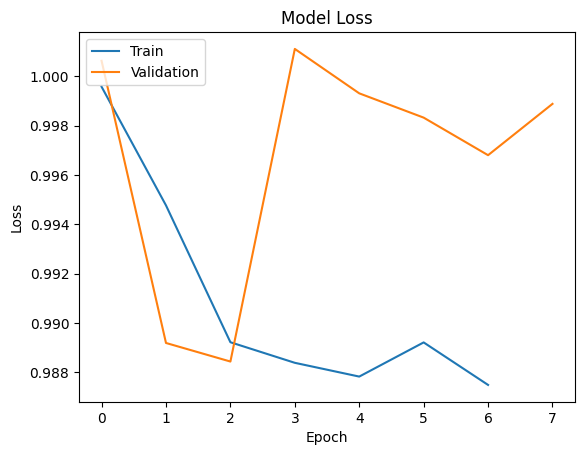

In [ ]:
# Plot training & validation loss values
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
fig = px.line(df_out, labels=dict(created_at="Date", value=" P_Solar[kW]"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()


In [ ]:
X_df = DATA.drop(['P_Solar[kW]'], axis=1).reset_index(drop=True)
#hot_afternoon_s = X_df
hot_afternoon_s = X_df[  (X_df['TEMPERATURE[degC]']<0)]
hot_morning_s=X_df[ (X_df.HoursOfDay>=8) & (X_df['TEMPERATURE[degC]']<=20)]
cold_morning_s=X_df[ (X_df.HoursOfDay<=8) & (X_df['TEMPERATURE[degC]']<10)]

In [ ]:
hot_afternoon_s.shape

(365, 18)

In [ ]:
pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.9 MB/s eta 0:00:00


In [ ]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(model)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
DATA=pd.read_hdf('SOLETE_Pombo_60min.h5')
#DATA=pd.read_csv('/content/Wind Time Series Dataset(hourly).csv')
PVinfo, WTinfo = import_PV_WT_data()

#%% Expand Dataset
ExpandSOLETE(DATA, [PVinfo, WTinfo], Control_Var)

Expanding SOLETE with King's PV Performance Model
Cleaning noise and curtailment from active power production
Smoothing zeros

Adding new Types with codes: ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]', 'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'Pressure[mbar]', 'Pac', 'Pdc', 'TempModule', 'TempCell', 'HoursOfDay', 'MeanPrevH', 'StdPrevH', 'MeanWindSpeedPrevH', 'StdWindSpeedPrevH']

SOLETE has been successfully expanded from: 9 to: 18 features.




In [ ]:
y_scaler = MinMaxScaler()
y_scaler.fit(DATA[['P_Solar[kW]']])
X_scaler = MinMaxScaler()
X_scaler.fit(DATA.drop(['P_Solar[kW]'], axis=1))

MinMaxScaler()

In [ ]:
y_all = y_scaler.transform(DATA[['P_Solar[kW]']])
X_all = X_scaler.transform(DATA.drop(['P_Solar[kW]'], axis=1))

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
gen_all_672 = TimeseriesGenerator(X_all, y_all, length=24,\
 batch_size=32)

In [ ]:
gen_all_672

In [ ]:
nidx =  len(hot_afternoon_s)  - 672
batch_X = gen_all_672[nidx//32][0]
print(batch_X.shape)

(32, 24, 17)


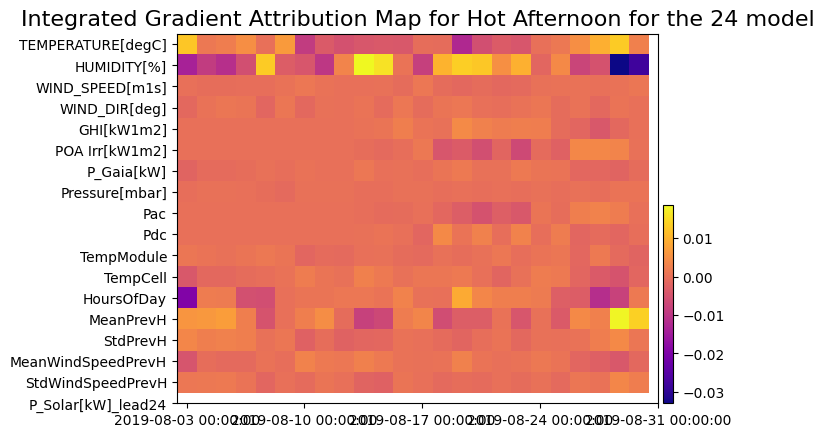

In [ ]:
# Integrated Gradients
nidx =  hot_afternoon_s.index.tolist()[0] - 672

batch_X1=batch_X.astype(np.float32)
batch_X1 = torch.from_numpy(batch_X1)
p = 5 #Create 5 tick marks…
f = '7D' #seperated by 1 week periods

attributions = ig.attribute(batch_X1)
#attribution_img = attributions.reshape(-1,attributions.shape[2])
attribution_img = np.transpose(attributions[nidx%32,:,:])
end_date = DATA.iloc[hot_afternoon_s.index].index.to_pydatetime()[0]
date_range = pd.date_range(end='2019-08-31', periods=p,\
freq=f).to_pydatetime().tolist()
columns = X_df.columns.tolist()
plt.title('Integrated Gradient Attribution Map for {} for the {} model'.format('Hot Afternoon', 24), fontsize=16)
plt.imshow(attribution_img, interpolation='nearest',\
aspect='auto', cmap='plasma')
plt.xticks(np.linspace(0,24,p).astype(int), labels=date_range)
plt.yticks([*range(18)], labels=columns)
plt.colorbar(pad=0.01,fraction=0.02,anchor=(1.0,0.0))
plt.show()

#CNN_LSTM_model(imfs from vmd + wavelet transformations)
find loss